# PARETO GENERAL

In [108]:
num_weeks = 56

# VENTAS

## OBTENER

In [109]:
import xmlrpc.client
from datetime import date, timedelta, datetime
import pandas as pd

# Conexión con Odoo (manteniendo tus credenciales)
username = "juan.cano@donsson.com"  # tu usuario
password = "1000285668"         # tu contraseña
url = "https://donsson.com"     # URL del servidor
db = "Donsson_produccion" # nombre de la base de datos


# --- Autenticación ---
common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")

# --- Fechas ---
weeks = num_weeks

# --- Fechas automáticas ---
hoy = date.today()
fecha_fin = hoy.strftime("%Y-%m-%d")
fecha_inicio = (hoy - timedelta(weeks=weeks)).strftime("%Y-%m-%d")

# --- 1) Buscar facturas válidas (account.invoice) ---

invoice_domain = [
    ("date_invoice", ">=", fecha_inicio),
    ("date_invoice", "<=", fecha_fin),
    ("type", "=", "out_invoice"),    # solo ventas
    ("state", "in", ["open", "paid"])
]

invoice_ids = models.execute_kw(
    db, uid, password,
    "account.invoice", "search",
    [invoice_domain]
)
print(f"Facturas encontradas: {len(invoice_ids)}")

# --- 2) Descargar las líneas de esas facturas (account.invoice.line) ---

# Campos de la LÍNEA de factura. Eliminamos 'number', 'user_id', 'section_id', 'partner_id' porque irán en la factura.
line_fields = ["product_id", "quantity", "price_subtotal", "invoice_id","create_date","origin"] 

records = []
limit = 20000
offset = 0

while True:
    result = models.execute_kw(
        db, uid, password,
        "account.invoice.line", "search_read",
        [[("invoice_id", "in", invoice_ids)]],
        {"fields": line_fields, "limit": limit, "offset": offset}
    )
    if not result:
        break
    records.extend(result)
    offset += limit
    print(f"Descargados {len(records)} registros de líneas...")

# --- 3) Pasar a DataFrame de líneas ---
line_df = pd.DataFrame(records).fillna(0)


# Separar product_id
line_df["product_id_num"] = line_df["product_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["product_name"] = line_df["product_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar invoice_id
line_df["invoice_id_num"] = line_df["invoice_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
line_df["invoice_name"] = line_df["invoice_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Convertir fecha a datetime
line_df["date_invoice"] = pd.to_datetime(line_df["create_date"], errors="coerce")

# Eliminar las columnas originales problemáticas
line_df = line_df.drop(columns=["product_id", "invoice_id","create_date"])

print(f"Total de líneas descargadas: {len(line_df)}")

# ----------------------------------------------------
# --- 4) Descargar los campos adicionales de Factura (account.invoice) ---
# ----------------------------------------------------
# Añadimos los campos que quieres: number, user_id, section_id, y también partner_id y store_id
invoice_fields = ["id", "store_id", "number", "user_id", "section_id", "partner_id"]
invoices = models.execute_kw(
    db, uid, password,
    "account.invoice", "read",
    [invoice_ids], # Solo las facturas que encontramos
    {"fields": invoice_fields}
)
invoice_df = pd.DataFrame(invoices)

# --- 5) Procesar campos de la factura ---

# Separar store_id
invoice_df["store_name"] = invoice_df["store_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else str(x)
)

# Separar user_id (Vendedor)
invoice_df["salesperson_name"] = invoice_df["user_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar section_id (Equipo de Ventas)
invoice_df["sales_team_name"] = invoice_df["section_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)

# Separar partner_id (Cliente/Partner)
invoice_df["partner_id_num"] = invoice_df["partner_id"].apply(
    lambda x: x[0] if isinstance(x, (list, tuple)) else None
)
# El nombre del partner es el segundo elemento de la tupla (si existe)
invoice_df["client_name_inv"] = invoice_df["partner_id"].apply(
    lambda x: x[1] if isinstance(x, (list, tuple)) else None
)


# Eliminar columnas originales no deseadas o ya procesadas
invoice_df = invoice_df.drop(columns=["store_id", "user_id", "section_id", "partner_id"])


# ----------------------------------------------------
# --- 6) Fusionar DataFrames ---
# ----------------------------------------------------

# Fusionamos las líneas de factura (line_df) con los datos de las facturas (invoice_df)
df = line_df.merge(
    invoice_df, 
    left_on="invoice_id_num", 
    right_on="id", 
    how="left"
)

# Limpieza final de columnas de IDs de factura
df = df.drop(columns=["invoice_id_num", "product_id_num"])


df['origin'] = df['origin'].astype('string')

#Tarda 7 minutos en 58 semanas

Facturas encontradas: 55365
Descargados 20000 registros de líneas...
Descargados 40000 registros de líneas...
Descargados 60000 registros de líneas...
Descargados 80000 registros de líneas...
Descargados 100000 registros de líneas...
Descargados 120000 registros de líneas...
Descargados 140000 registros de líneas...
Descargados 160000 registros de líneas...
Descargados 180000 registros de líneas...
Descargados 200000 registros de líneas...
Descargados 215284 registros de líneas...
Total de líneas descargadas: 215284


## PROCESAR

In [110]:
def clasificar_sucursal(invoice_name):
    if pd.isna(invoice_name):
        return "VENDEDOR EXTERNO"
    if "Mostrador" in invoice_name:
        return "MOSTRADOR"
    return "VENDEDOR EXTERNO"
    
df["Sucursal_tipo"] = df["invoice_name"].apply(clasificar_sucursal)


mapa_sucursales = {
    'BD1': 'PRINCIPAL COTA',
    'BD2': 'SUCURSAL CALLE 6',
    'BD3': 'SUCURSAL VALLADOLID',
    'BD4': 'SUCURSAL NORTE',
    'BD5': 'SUCURSAL MEDELLIN',
    'BD6': 'SUCURSAL BARRANQUILLA',
    'BD7':' SUCURSAL BUCARAGAMNGA ',
    'BD8':'MOSTRADOR COTA',
    'BD9':'SUCURSAL CALI',
    'BD11': 'CUMMINS DE LOS ANDES',
    'BD12': 'CUMMINS DE LOS ANDES MEDELLIN',
    'BD13': 'CSS CONSTRUCTORES',
    'BD14': 'ANTIOQUEÑA DE LUBRICANTES SGP SAS',
    'BD15': 'ASEO CAPITAL',
    'BD16': 'COVIANDES',
    'BD18': 'CEMEX BOSA',
    'BD19': 'Cemex ibague (eliminar)',
    'BD21': 'CEMEX CENTENARIO',
    'BD22': 'PENDIENTE POR FACTURAR CIERRE CONT.',
    'BD24': 'FILTRO EN REPROCESO',
    'BD26': 'PRESTAMOS INTERNOS',
    'BD31': 'EXP.CTP',
    'BD32': 'EXP. ECUADOR',
    'BD34':'EXP.DONSSON.USA',
    'BD40': 'DESCUADRE B1',
    'BD MP':'MATERIA PRIMA',
    'BD41':'BODEGA VENDEDOR WILMER GIL',
    'BD33':'EXP.REP.DOMINICANA',
    'BD42':'STOCK SIGMA ENERGY'
    # Agrega más códigos si los encuentras en tus datos, siguiendo este formato.
    }


#Quitar las facturas que salen como SO son no vendibles
df = df[~(df["origin"].str.contains("SO"))] 


# Normalizar los separadores para que todos sean iguales
df["origin_norm"] = df["origin"].str.replace(r"[\\/]", "/", regex=True)

# Extraer solo el BD y el número (ejemplo: BD11, BD9, etc.)
df["origen"] = df["origin_norm"].str.extract(r"^(BD\d+)")

df["Bodega"] = df["origen"].map(mapa_sucursales)
df["Bodega"] = df["Bodega"].fillna(df["store_name"])

df = df.drop(columns=["origin_norm"])



# ===============================
# Procesar ventas normales
# ===============================
df_sales = df.copy()
df_sales["date_invoice"] = pd.to_datetime(df_sales["date_invoice"], errors="coerce")


# Referncia de producto
df_sales["product_ref"] = df_sales["product_name"].str.extract(r"\[([A-Z0-9]+)\]")


# Columnas temporales igual que en df_vp
df_sales["Semana"] = df_sales["date_invoice"].dt.to_period("W").dt.start_time
df_sales["ano"]    = df_sales["Semana"].dt.year
df_sales["mes"]    = df_sales["Semana"].dt.month
df_sales["dia"]    = df_sales["Semana"].dt.day

# ===============================
# Agrupación por tienda + producto + semana
# ===============================
sales = (
    df_sales.groupby(["product_ref", "Semana", "ano", "mes", "dia"], as_index=False)
    .agg(
        sales=("quantity", "sum"),              # suma de unidades vendidas
        num_facturas=("date_invoice", "nunique")  # cantidad de facturas distintas
    )
)


# Resultado
sales.sample(10)



,product_ref,Semana,ano,mes,dia,sales,num_facturas
10907,BCS00734125,2025-09-08,2025,9,8,1.0,1
398,ALG20W50030,2025-03-24,2025,3,24,1.0,1
16323,BHS10260125,2025-05-19,2025,5,19,1.0,1
44452,DAS07803025,2024-09-16,2024,9,16,7.0,4
47607,DCS00035189,2025-08-04,2025,8,4,2.0,1
40212,DAR02122025,2025-06-23,2025,6,23,3.0,3
17012,BLE00978125,2025-02-10,2025,2,10,1.0,1
17077,BLS00001125,2024-10-07,2024,10,7,161.0,23
50565,DLE01323189,2025-06-02,2025,6,2,2.0,1
4687,BCE10606125,2025-09-29,2025,9,29,2.0,2


# VENTAS PERDIDAS

## OBTENER

In [111]:
import xmlrpc.client
from datetime import date, timedelta
import pandas as pd

# ===============================
# 1. Conexión con Odoo
# ===============================

ODOO_URL = "https://donsson.com"
ODOO_DB = "Donsson_produccion"
ODOO_USERNAME = "juan.cano@donsson.com"
ODOO_PASSWORD = "1000285668"

# Autenticación
common = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/common")
uid = common.authenticate(ODOO_DB, ODOO_USERNAME, ODOO_PASSWORD, {})
if not uid:
    print("Error de autenticación. Verifica tus credenciales.")
    exit()
models = xmlrpc.client.ServerProxy(f"{ODOO_URL}/xmlrpc/2/object")

# ===============================
# 2. Definir rango de semanas
# ===============================

# Número de semanas que quieres descargar (puedes cambiarlo)
NUM_SEMANAS = num_weeks

# Fecha de hoy
hoy = date.today()
# Fecha de inicio según número de semanas atrás
fecha_inicio = hoy - timedelta(weeks=NUM_SEMANAS)

FECHA_INICIO = fecha_inicio.strftime("%Y-%m-%d")
FECHA_FIN = hoy.strftime("%Y-%m-%d")

print(f"📅 Descargando registros desde {FECHA_INICIO} hasta {FECHA_FIN}")

# ===============================
# 3. Leer ventas perdidas
# ===============================

lost_sales_ids = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "search",
    [[["fecha", ">=", FECHA_INICIO], ["fecha", "<=", FECHA_FIN], ["almacenamiento_tipo", "=", "agotado"]]]
)

lost_sales_data = models.execute_kw(
    ODOO_DB, uid, ODOO_PASSWORD,
    "ventas.perdidas", "read",
    [lost_sales_ids],
    {"fields": ["origen", "store_id", "cliente_id", "fecha", "product_ref",
                "cantidad", "cantidad_existencia", "cantidad_reservada",
                "almacenamiento_tipo"]}
)

df = pd.DataFrame(lost_sales_data)

# ===============================
# 4. Normalizar columnas
# ===============================

for col in ["store_id", "cliente_id"]:
    df[col.replace('_id', '_name')] = df[col].apply(
        lambda x: x[1] if isinstance(x, (list, tuple)) and len(x) > 1 else str(x) if x else None
    )
    df[col + "_num"] = df[col].apply(
        lambda x: x[0] if isinstance(x, (list, tuple)) and len(x) > 0 else None
    )

# Eliminar columnas originales
df = df.drop(columns=["id", "store_id", "cliente_id"], errors='ignore')

# ===============================
# 4.1. Forzar tipos de columnas antes de exportar
# ===============================
for col in df.columns:
    if col.endswith("_num"):
        df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")
    else:
        df[col] = df[col].astype("string")

vp = df.copy()



📅 Descargando registros desde 2024-09-09 hasta 2025-10-06


## PROCESAR

In [112]:
import pandas as pd
import numpy as np

# ===============================
# Filtrar almacenamiento agotado
# ===============================
vp = vp[vp["almacenamiento_tipo"].str.lower() == "agotado"]

# ===============================
# Asegurar tipos correctos
# ===============================
vp = vp.copy()
vp["fecha"] = pd.to_datetime(vp["fecha"], errors="coerce")

# Numéricos
for col in ["cantidad", "cantidad_existencia", "cantidad_reservada"]:
    vp[col] = pd.to_numeric(vp[col], errors="coerce").fillna(0).clip(lower=0)

# ===============================
# Reglas Odoo vectorizadas
# ===============================
is_cot = vp["origen"].fillna("").str.lower() == "cotizacion"
ignore_mask = vp["cantidad"] >= 100

ajuste = np.where(
    is_cot,
    vp["cantidad"] - vp["cantidad_existencia"] - vp["cantidad_reservada"],
    vp["cantidad"] - vp["cantidad_reservada"]
)

# Aplicar reglas de descarte y piso en cero
ajuste = np.where(ignore_mask, 0, ajuste)
ajuste = np.where(ajuste > 0, ajuste, 0)

vp["ventas_perdidas"] = ajuste.astype(float)

# ===============================
# Columnas temporales
# ===============================
vp["Semana"] = vp["fecha"].dt.to_period("W").dt.start_time
vp["ano"]   = vp["Semana"].dt.year
vp["mes"]   = vp["Semana"].dt.month
vp["dia"]   = vp["Semana"].dt.day

# ===============================
# Filtro adicional: excluir SERV y CARCASA
# ===============================
mask_excluir = ~vp["product_ref"].str.contains("SERV|CARCASA", case=False, na=False)
vp = vp[mask_excluir]

# ===============================
# Agrupación por tienda + producto + semana
# ===============================
lost_by_week = (
    vp.groupby(["product_ref", "Semana", "ano", "mes", "dia"])
    .agg(
        lost_sales=("ventas_perdidas", "sum"),   # suma total de ventas perdidas
        veces_vp=("ventas_perdidas", "count")    # número de veces que hubo pérdida
    )
    .reset_index()
)

# Mostrar resultado agrupado
vp = lost_by_week

In [113]:
vp.sample(10)

,product_ref,Semana,ano,mes,dia,lost_sales,veces_vp
27676,DAC00208020,2024-09-23,2024,9,23,1.0,1
33754,DAR02427025,2024-10-21,2024,10,21,8.0,2
15304,BHS00349125,2024-12-23,2024,12,23,1.0,1
37718,DCE00990189,2025-08-18,2025,8,18,6.0,4
11483,BCS00764125,2025-07-21,2025,7,21,5.0,3
10700,BCS00605125,2025-05-26,2025,5,26,3.0,3
19087,BLS00268125,2024-12-16,2024,12,16,2.0,2
23564,DAB08032115,2025-03-10,2025,3,10,1.0,1
11683,BCS10126125,2025-07-14,2025,7,14,1.0,1
13976,BHE00829125,2025-04-28,2025,4,28,1.0,1


# COSTOS

## OBTENER

In [114]:
import xmlrpc.client
import pandas as pd


# ===============================
# Conexión con Odoo
# ===============================
username = "juan.cano@donsson.com"   # tu usuario
password = "1000285668"              # tu contraseña
url = "https://donsson.com"          # URL del servidor
db = "Donsson_produccion"            # nombre de la base de datos

common = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/common")
uid = common.authenticate(db, username, password, {})
models = xmlrpc.client.ServerProxy(f"{url}/xmlrpc/2/object")


#df_campos.info()


productos_costo = models.execute_kw(
    db , uid , password,
    "cs.analisis.costo","search_read",
    [[]],
    {"fields":["producto_costo_unitario","producto_id","producto_marca"]}


)

# Convertir en df
df_p = pd.DataFrame(productos_costo)


# Separar lista anidada
df_p[["product_id_num","product_name"]] = (df_p["producto_id"].apply(pd.Series))

#Agregar columna estandarizada
df_p["product_name"] = df_p["product_name"].str.strip()

#DF normalizado
df_p = df_p[["product_name","producto_costo_unitario","producto_marca"]]

In [115]:
df_p.head()

,product_name,producto_costo_unitario,producto_marca
0,[DAB02570025] DA2570 FILTRO AIRE DONSSON - PER...,13645.86,DONSSON
1,"[BLS00037125] GS037 FILTRO ACEITE MACK, CATERP...",32797.97,BALDWIN
2,[DAB14570025] DA4570A FILTRO AIRE 2_ DONSSON -...,10135.85,DONSSON
3,"[BCS00035125] GS035 FILTRO COMBUSTIBLE VOLVO,D...",20638.72,BALDWIN
4,"[DAB02772025] DA2772 FILTRO AIRE BOBCAT, HITAC...",10883.85,DONSSON


## PROCESAR

In [132]:
df_p["product_ref"] = df_p["product_name"].str.extract(r"\[([A-Z0-9]+)\]")

df_p_unique = (
    df_p[["product_ref", "producto_costo_unitario","producto_marca"]]
    .drop_duplicates(subset=["product_ref"])
)

In [133]:
sales.head()

,product_ref,Semana,ano,mes,dia,sales,num_facturas
0,AC000005020,2024-09-09,2024,9,9,2.0,1
1,AC10388020,2025-01-13,2025,1,13,2.0,1
2,AC10388020,2025-02-24,2025,2,24,10.0,1
3,AC10388020,2025-07-07,2025,7,7,2.0,1
4,AC10388020,2025-07-21,2025,7,21,2.0,1


# UNION

In [118]:
vp.head()

,product_ref,Semana,ano,mes,dia,lost_sales,veces_vp
0,AC000001222,2025-01-20,2025,1,20,1.0,1
1,AC000002222,2025-01-20,2025,1,20,1.0,1
2,AC000002222,2025-01-27,2025,1,27,1.0,1
3,AC000005020,2024-09-09,2024,9,9,1.0,1
4,AC000005020,2024-12-30,2024,12,30,1.0,1


# VENTAS A VP

In [134]:
df_merged = pd.merge(
    sales[["product_ref", "Semana", "sales", "num_facturas"]],
    vp[["product_ref", "Semana", "lost_sales", "veces_vp"]],
    on=["product_ref", "Semana"],
    how="outer"
).fillna(0)

# Pasar de semanas a meses
df_merged["Mes"] = df_merged["Semana"].dt.to_period("M").dt.to_timestamp()

# Consolidar por producto y mes
df_merged = (
    df_merged
    .groupby(["product_ref", "Mes"], as_index=False)
    .agg({
        "sales": "sum",
        "num_facturas": "sum",
        "lost_sales": "sum",
        "veces_vp": "sum"
    })
)

# Añadir columnas de año y mes
df_merged["año"] = df_merged["Mes"].dt.year
df_merged["mes"] = df_merged["Mes"].dt.month



In [135]:
df_merged.sample(10)

,product_ref,Mes,sales,num_facturas,lost_sales,veces_vp,año,mes
17299,DAB08069025,2025-05-01,3.0,3.0,6.0,7.0,2025,5
13628,BLS00308125,2024-11-01,0.0,0.0,4.0,4.0,2024,11
25906,DAR03144025,2025-02-01,3.0,2.0,3.0,3.0,2025,2
14217,BLS00572125,2025-02-01,1.0,1.0,1.0,1.0,2025,2
27397,DCE00390189,2025-08-01,15.0,8.0,8.0,9.0,2025,8
7970,BCS00746125,2024-10-01,3.0,1.0,3.0,3.0,2024,10
5314,BCE10727125,2024-12-01,1.0,1.0,1.0,1.0,2024,12
26916,DAS07827025,2024-10-01,8.0,2.0,7.0,2.0,2024,10
31014,DCX20225137,2025-09-01,4.0,4.0,8.0,11.0,2025,9
3355,BAE09058125,2024-09-01,0.0,0.0,7.0,7.0,2024,9


# EMA

In [121]:
import pandas as pd
import numpy as np

def compute_demand_and_ema(df,
                           alpha=0.20,        # peso de EMA
                           n_init=12,   # semanas o meses para inicializar EMA
                           date_col="Mes", #Semana o Mes
                           sales_col="sales",
                           lost_col="lost_sales",
                           freq ="M" # "W-MON" semanas y "M" meses
                           ):
    df = df.copy()

    # ---------- Asegurar tipos y semana iniciando lunes ----------
    df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
    df[date_col] = df[date_col].dt.to_period(freq).dt.start_time #W_MON para lunes en semanas M para primer dia del mes

    # Asegurar numéricos
    df[sales_col] = pd.to_numeric(df[sales_col], errors="coerce").fillna(0)
    df[lost_col]  = pd.to_numeric(df[lost_col], errors="coerce").fillna(0)

    # ---------- Crear combinaciones completas ----------
    #stores   = df["store_name"].unique()
    products = df["product_ref"].unique()


    # Crear rango completo desde min hasta max semana
    weeks = pd.period_range(df[date_col].min(), df[date_col].max(), freq=freq).to_timestamp()


    full_index = pd.MultiIndex.from_product([products, weeks],
                                            names=["product_ref", date_col])

    df = df.set_index(["product_ref", date_col]).reindex(full_index).reset_index()

    # Rellenar ventas y perdidas con 0 en combinaciones faltantes
    df[sales_col] = df[sales_col].fillna(0)
    df[lost_col]  = df[lost_col].fillna(0)

    # Ordenar
    df = df.sort_values(["product_ref", date_col])

    out_groups = []

    # ---------- Calcular demanda ajustada y EMA ----------
    for (prod), g in df.groupby("product_ref", sort=False):
        g = g.sort_values(date_col).reset_index(drop=True)
        sales = g[sales_col].to_numpy(dtype=float)
        lost  = g[lost_col].to_numpy(dtype=float)

        L = len(g)
        demanda = np.zeros(L, dtype=float)
        ema_arr = np.zeros(L, dtype=float)

        if L == 0:
            out_groups.append(g)
            continue

        # Inicialización EMA: promedio de primeras n_init ventas
        init_n = min(n_init, L)
        ema_prev = float(np.nanmean(sales[:init_n])) if init_n > 0 else 0.0
        if np.isnan(ema_prev):
            ema_prev = 0.0

        for i in range(L):
            s = sales[i]
            l = lost[i]

            # Regla 1
            if s >= 2.0 * l:
                demand_candidate = s + l
                demand = min(demand_candidate, 1.5 * s) if s > 0 else demand_candidate
            else:
                # Regla 2
                demand = s + 0.5 * ema_prev

            # Guardar redondeando
            demanda[i] = round(demand, 6)

            # Calcular EMA
            ema = alpha * demand + (1.0 - alpha) * ema_prev
            ema = round(ema, 6)
            ema_arr[i] = ema

            # actualizar para siguiente
            ema_prev = ema

        # Añadir columnas al grupo
        g = g.copy()
        g["demanda_ajustada"] = demanda
        g["EMA"] = ema_arr

        out_groups.append(g)

        

    # Concat resultados
    result = pd.concat(out_groups, ignore_index=True, sort=False)
    result = result.sort_values(["product_ref", date_col]).reset_index(drop=True)
    return result

# ------------------ USO ------------------
df_with_demand1 = compute_demand_and_ema(df_merged, alpha=0.2, n_init=12) 

In [122]:
df_with_demand1.sample(10)

,product_ref,Mes,sales,num_facturas,lost_sales,veces_vp,año,mes,demanda_ajustada,EMA
28864,DAB04967025,2025-07-01,2.0,1.0,0.0,0.0,2025.0,7.0,2.000000,2.338776
37484,DAE01133136,2025-03-01,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000
34983,DAC10211020,2025-08-01,10.0,2.0,1.0,1.0,2025.0,8.0,11.000000,5.157493
54215,DCE10930138,2025-04-01,3.0,2.0,11.0,1.0,2025.0,4.0,24.769331,39.784796
59195,DLE00594136,2024-12-01,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000
38211,DAE02432025,2025-02-01,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000
57306,DCX00245138,2025-01-01,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,1.329493
45149,DAE61083136,2025-10-01,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000
52451,DCE00655189,2025-04-01,0.0,0.0,1.0,1.0,2025.0,4.0,0.092059,0.165706
48334,DAR08083025,2025-03-01,1.0,1.0,0.0,0.0,2025.0,3.0,1.000000,0.322334


In [123]:
def add_deviation_and_classification(df, ema_col="EMA", sales_col="sales", date_col="Mes", n_init=12):
    """
    Calcula desviación y coeficiente de ventas por producto
    y normaliza coef_ventas usando percentiles.
    """
    df = df.copy()
    out_groups = []

    for (prod), g in df.groupby("product_ref", sort=False):
        g = g.sort_values(date_col).reset_index(drop=True)
        
        sales = g[sales_col].to_numpy(dtype=float)
        ema   = g[ema_col].to_numpy(dtype=float)
        L = len(sales)

        # Inicializamos columnas
        g["desviacion_ema%"] = 0.0
        g["coef_ventas"] = 0.0

        if L < 2:
            out_groups.append(g)
            continue

        for i in range(L):
            # Usar solo hasta el mes actual (i)
            window_start = max(0, i - n_init)
            window_sales = sales[window_start:i]
            window_ema   = ema[window_start:i]

            if len(window_sales) < 2:
                continue

            promedio_prev = np.mean(window_sales)
            if promedio_prev == 0:
                promedio_prev = 1e-6

            # --- Desviación usando EMAs previos ---
            desv = np.std(window_ema, ddof=1) / promedio_prev if promedio_prev > 0 else 0

            # --- Coeficiente de ventas ---
            coef = (max(window_sales) - min(window_sales)) / promedio_prev if promedio_prev > 0 else 0

            g.at[i, "desviacion_ema%"] = round(desv, 2)
            g.at[i, "coef_ventas"] = coef

        out_groups.append(g)

    df_out = pd.concat(out_groups, ignore_index=True)

    # --- Normalización por percentiles ---
    df_out["coef_ventas_norm"] = df_out.groupby("product_ref")["coef_ventas"].transform(
        lambda x: x.rank(pct=True)
    )

    return df_out



In [124]:
df_with_demand2 = add_deviation_and_classification(df_with_demand1)

In [125]:
df_with_demand2.sample(20)

,product_ref,Mes,sales,num_facturas,lost_sales,veces_vp,año,mes,demanda_ajustada,EMA,desviacion_ema%,coef_ventas,coef_ventas_norm
1650,BAB04666125,2025-09-01,0.0,0.0,1.0,1.0,2025.0,9.0,0.000000,0.000000,0.00,0.000000,0.535714
52673,DCE00732134,2025-02-01,0.0,0.0,6.0,6.0,2025.0,2.0,0.000000,0.000000,0.00,0.000000,0.535714
26880,CS133102222,2024-09-01,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000,0.00,0.000000,0.535714
7017,BAE06500125,2024-12-01,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000,0.00,0.000000,0.535714
44264,DAE09242025,2025-07-01,8.0,4.0,27.0,5.0,2025.0,7.0,12.935741,10.484335,0.09,1.139241,0.857143
51242,DCE00502189,2024-11-01,0.0,NaN,0.0,NaN,NaN,NaN,0.000000,0.000000,0.00,0.000000,0.535714
44522,DAE18022025,2024-11-01,0.0,0.0,20.0,1.0,2024.0,11.0,9.900000,17.820000,0.06,2.000000,0.214286
52685,DCE00753138,2024-12-01,6.0,1.0,24.0,2.0,2024.0,12.0,6.216000,1.588800,85135.19,0.000000,0.178571
485,ALG10W30051,2025-06-01,4.0,4.0,0.0,0.0,2025.0,6.0,4.000000,1.947134,0.21,1.800000,0.714286
47102,DAR02755025,2025-03-01,4.0,3.0,0.0,0.0,2025.0,3.0,4.000000,6.186034,0.23,3.454545,0.500000


In [126]:
df_with_demand2 = df_with_demand2[["product_ref","Mes","num_facturas","sales","lost_sales","demanda_ajustada","EMA","desviacion_ema%","coef_ventas","coef_ventas_norm","veces_vp"]]

In [127]:
df_last_month = df_with_demand2[df_with_demand2["Mes"]=="2025-09-01"]

In [128]:
df_last_month

,product_ref,Mes,num_facturas,sales,lost_sales,demanda_ajustada,EMA,desviacion_ema%,coef_ventas,coef_ventas_norm,veces_vp
12,AC000001222,2025-09-01,NaN,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.535714,NaN
26,AC000002222,2025-09-01,NaN,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.535714,NaN
40,AC000005020,2025-09-01,NaN,0.0,0.0,0.000000,0.056694,1.28,12.000000,1.000000,NaN
54,AC00389020,2025-09-01,NaN,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.535714,NaN
68,AC10388020,2025-09-01,2.0,4.0,37.0,4.749899,2.149818,0.56,7.500000,0.892857,5.0
...,...,...,...,...,...,...,...,...,...,...,...
62004,SERV4,2025-09-01,NaN,0.0,0.0,0.000000,0.932273,0.22,2.181818,0.607143,NaN
62018,SERV5,2025-09-01,NaN,0.0,0.0,0.000000,0.057010,0.74,12.000000,0.964286,NaN
62032,SERV6,2025-09-01,NaN,0.0,0.0,0.000000,0.164582,0.66,12.000000,0.964286,NaN
62046,SERV7,2025-09-01,1.0,165.0,0.0,165.000000,61.674394,0.47,8.040000,1.000000,0.0


## UNIR COSTO

In [146]:
df_merge_def = pd.merge(
    df_last_month,
    df_p_unique[["product_ref", "producto_marca","producto_costo_unitario"]],
    on="product_ref",
    how="outer" #para incluir todos , estaba antes left
).fillna(0)

ultimo_mes = df_last_month["Mes"].max()
df_merge_def["Mes"] = ultimo_mes

df_merge_def["año"] = df_merge_def["Mes"].dt.year
df_merge_def["mes"] = df_merge_def["Mes"].dt.month



merge_def =  df_merge_def.copy()

In [147]:
df_p_unique.head()

,product_ref,producto_costo_unitario,producto_marca
0,DAB02570025,13645.86,DONSSON
1,BLS00037125,32797.97,BALDWIN
2,DAB14570025,10135.85,DONSSON
3,BCS00035125,20638.72,BALDWIN
4,DAB02772025,10883.85,DONSSON


In [148]:
merge_def.sort_values(by=["desviacion_ema%"], ascending =True).sample(5)

,product_ref,Mes,num_facturas,sales,lost_sales,demanda_ajustada,EMA,desviacion_ema%,coef_ventas,coef_ventas_norm,veces_vp,producto_marca,producto_costo_unitario,año,mes
4729,DLS00041010,2025-09-01,0.0,0.0,1.0,0.000000,0.000000,0.00,0.000000,0.535714,1.0,OTROS,2076.09,2025,9
1532,BHS00526125,2025-09-01,0.0,0.0,0.0,0.000000,0.000000,0.00,0.000000,0.535714,0.0,BALDWIN,4399.07,2025,9
4292,DCS00331115,2025-09-01,0.0,0.0,4.0,0.046577,0.083839,0.77,12.000000,0.964286,4.0,OTROS,10534.42,2025,9
1117,BCS00747125,2025-09-01,1.0,4.0,10.0,7.756802,7.562244,0.31,2.947368,0.750000,5.0,BALDWIN,57677.58,2025,9
4288,DCS00292138,2025-09-01,1.0,2.0,5.0,3.173650,2.512570,0.38,3.000000,0.892857,3.0,RACOR USA,101191.21,2025,9


In [149]:
merge_def["coef_ventas"].describe()

count    4889.000000
mean        2.728584
std         3.782813
min         0.000000
25%         0.000000
50%         0.982857
75%         4.000000
max        12.000000
Name: coef_ventas, dtype: float64

<Axes: >

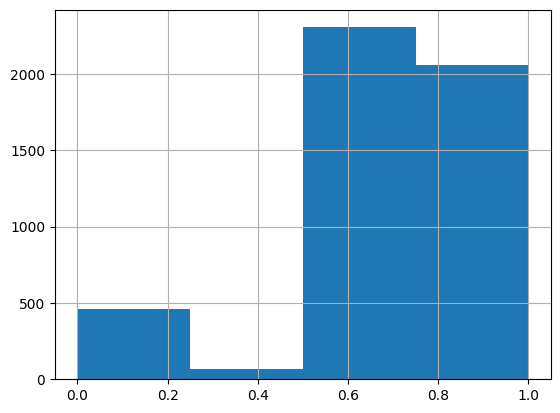

In [158]:
import matplotlib.pyplot as plt

merge_def["coef_ventas_norm"].hist(bins=4)

<Axes: >

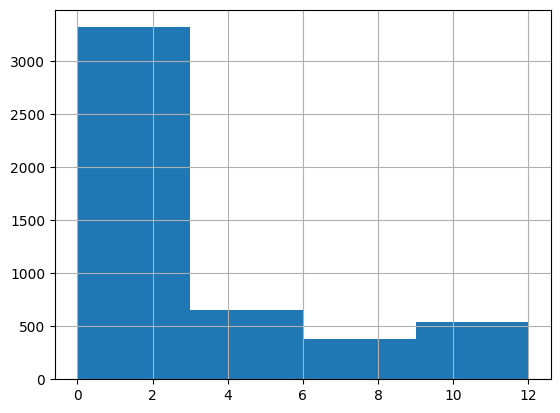

In [159]:
merge_def["coef_ventas"].hist(bins=4)

# CLASIFICACION

In [151]:
# Copia de trabajo
ema = merge_def.copy()

# -------------------------------
# 1. Calcular venta_costo_ema
# -------------------------------
ema["venta_costo_ema"] = (ema["EMA"] * ema["producto_costo_unitario"]).round(2)

# -------------------------------
# 2. Totales globales (NO por product_ref)
# -------------------------------
total_ema_global = ema["EMA"].sum()
total_costo_global = ema["venta_costo_ema"].sum()

# -------------------------------
# 3. Proporciones globales
# -------------------------------
ema["venta_costo%"] = (ema["venta_costo_ema"] / total_costo_global).round(6)
ema["cantidad%"] = (ema["EMA"] / total_ema_global).round(6)

# -------------------------------
# 4. Orden global y acumulados
# -------------------------------
# Ordenar por costo (mayor a menor)
ema = ema.sort_values("venta_costo_ema", ascending=False)
ema["acumulado_costo"] = ema["venta_costo%"].cumsum().round(4)

# Ordenar por cantidad (mayor a menor)
ema = ema.sort_values("EMA", ascending=False)
ema["acumulado_cantidad"] = ema["cantidad%"].cumsum().round(4)

# -------------------------------
# 5. Acumulado de desviación (si existe)
# -------------------------------
if "desviacion_ema%" in ema.columns:
    ema = ema.sort_values("desviacion_ema%", ascending=False)
    ema["acumulado_desviacion"] = ema["desviacion_ema%"].cumsum().round(4)

# -------------------------------
# 5. Renombrar columnas (estilo reporte Odoo)
# -------------------------------
ema_def = ema.rename(
    columns={
        "año": "Año",
        "semana_num": "semana",
        "EMA": "Ema",
        "producto_costo_unitario": "Costo unitario",
        "venta_costo_ema": "Venta costo EMA",
        "venta_costo%": "Venta costo %",
        "acumulado_costo": "Acumulado costo",
        "desviacion_ema%": "Desviacion EMA %",
    }
)

# -------------------------------
# 6. Calcular desviación en dinero
# -------------------------------
if "Desviacion EMA %" in ema_def.columns:
    ema_def["Desviacion EMA"] = (
        ema_def["Venta costo EMA"] * ema_def["Desviacion EMA %"]
    ).round(1)



# Ejemplo de reglas (lo que viene de conf_acumulado_desviacion en Odoo) #PERILLA
reglas = [
    {"rango_ini": 0, "rango_fin": 0.5, "valor": 0},
    {"rango_ini": 0.5, "rango_fin": 0.75, "valor": 0.5},
    {"rango_ini": 0.75, "rango_fin": 0.9, "valor": 0.8},
    {"rango_ini": 0.9, "rango_fin": 1, "valor": 1},
]

# aplicar reglas 0–0.8–1 como antes, pero sobre coef_ventas_norm


# Función que asigna el valor según reglas
def asignar_desviacion(coef, reglas):
    for r in reglas:
        if r["rango_ini"] <= coef <= r["rango_fin"]:
            return r["valor"]
    return np.nan  # si no entra en ningún rango

# Aplicar
ema_def["acumulado_desviacion_p"] = ema_def["coef_ventas_norm"].apply(
    lambda x: asignar_desviacion(x, reglas)
)



# -------------------------------
# 7. Limpiar columnas innecesarias
# -------------------------------
if "Unnamed: 0" in ema_def.columns:
    ema_def = ema_def.drop(columns=["Unnamed: 0"])


# 8. Reglas acumulado costo combinado
# --- Configuración ---
def check_div(a, b):
    try:
        return a / b if b != 0 else 0
    except Exception:
        return 0

## PERILLA

conf_porcentajes_impacto = {
    "cantidad": 0.5,
    "costo": 0.3,
    "desviacion": 0.2,
    "cantidad_mayor": 0.7,
    "costo_mayor": 0.3,
}

# Valor de referencia en porcentaje (ejemplo: 10%) ##PERILLA
conf_acumulado_cantidad = 80
conf_acumulado_cantidad_desviacion = check_div(conf_acumulado_cantidad, 100)


# --- Cálculo en el DataFrame ---
def calcular_combinado(row):
    acumulado_cantidad_final = round(row["acumulado_cantidad"], 2)
    acumulado_costo_final = round(row["Acumulado costo"], 2)
    acumulado_desviacion_p_final = round(row["acumulado_desviacion_p"], 2)

    if acumulado_cantidad_final >= conf_acumulado_cantidad_desviacion:
        return (
            acumulado_cantidad_final * conf_porcentajes_impacto["cantidad_mayor"]
            + acumulado_costo_final * conf_porcentajes_impacto["costo_mayor"]
        )
    else:
        return (
            acumulado_cantidad_final * conf_porcentajes_impacto["cantidad"]
            + acumulado_costo_final * conf_porcentajes_impacto["costo"]
            + acumulado_desviacion_p_final * conf_porcentajes_impacto["desviacion"]
        )

# Nueva columna en tu df
ema_def["acumulado_combinado"] = ema_def.apply(calcular_combinado, axis=1).round(2)


def clasificar_pareto(valor):
    if valor <= 0.50:
        return "AAA"
    elif valor < 0.8:
        return "A"
    elif valor < 0.95:
        return "B"
    else:
        return "C"

ema_def["Clasificacion"] = ema_def["acumulado_combinado"].apply(clasificar_pareto)


# Asegurar Mes como datetime y crear Año/Mes_num (enteros)
ema_def["Mes"] = pd.to_datetime(ema_def["Mes"], errors="coerce")
ema_def = ema_def.dropna(subset=["Mes"]).copy()
ema_def["Año"] = ema_def["Mes"].dt.year.astype(int)
ema_def["Mes_num"] = ema_def["Mes"].dt.month.astype(int)


ema_def = ema_def[ema_def["Año"]>2000]
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)



In [152]:
ema_def = ema_def[ema_def["Costo unitario"]!=0]
ema_def[["acumulado_cantidad", "Acumulado costo", "acumulado_desviacion_p"]].describe()


,acumulado_cantidad,Acumulado costo,acumulado_desviacion_p
count,4702.000000,4702.000000,4702.000000
mean,0.949543,0.941116,0.624032
std,0.127704,0.139490,0.321605
min,0.022700,0.018200,0.000000
25%,0.975400,0.963725,0.500000
50%,0.999700,0.999900,0.500000
75%,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000


In [153]:
ema_def.sort_values(by=["acumulado_combinado"], ascending=False)

ema_def["acumulado_combinado"].min()

np.float64(0.03)

In [154]:
ema_def.head()

,product_ref,Mes,num_facturas,sales,lost_sales,demanda_ajustada,Ema,Desviacion EMA %,coef_ventas,coef_ventas_norm,veces_vp,producto_marca,Costo unitario,Año,mes,Venta costo EMA,Venta costo %,cantidad%,Acumulado costo,acumulado_cantidad,acumulado_desviacion,Desviacion EMA,acumulado_desviacion_p,acumulado_combinado,Clasificacion,Mes_num
1086,BCS00676125,2025-09-01,0.0,0.0,0.0,0.000000,0.364597,1.40,12.0,0.964286,0.0,BALDWIN,13222.41,2025,9,4820.85,0.000002,0.000006,0.9997,0.9986,1.40,6749.2,1.0,1.00,C,9
1145,BCS10228125,2025-09-01,0.0,0.0,0.0,0.000000,0.338438,1.37,12.0,0.964286,0.0,BALDWIN,62082.19,2025,9,21010.97,0.000011,0.000005,0.9981,0.9988,2.77,28785.0,1.0,1.00,C,9
508,BAE04524125,2025-09-01,0.0,0.0,5.0,0.791762,1.425172,1.34,12.0,0.964286,5.0,BALDWIN,78293.00,2025,9,111580.99,0.000057,0.000023,0.9813,0.9925,4.11,149518.5,1.0,0.99,C,9
3070,DAE05128004,2025-09-01,0.0,0.0,0.0,0.000000,0.364174,1.32,12.0,0.964286,0.0,AUT*PARTS,1694.96,2025,9,617.26,0.000000,0.000006,1.0000,0.9986,5.43,814.8,1.0,1.00,C,9
1864,BLS00521125,2025-09-01,0.0,0.0,0.0,0.000000,0.090812,1.30,12.0,1.000000,0.0,BALDWIN,18822.53,2025,9,1709.31,0.000001,0.000001,0.9999,0.9998,6.73,2222.1,1.0,1.00,C,9


In [155]:
ema_def.to_excel("/home/donsson/proyectos/MODELO ABASTECIMIENTO/exceles/prueba_pareto_general.xlsx")

In [156]:
ema_def["Clasificacion"].value_counts()

Clasificacion
C      3752
B       577
A       288
AAA      85
Name: count, dtype: int64